# 1 - Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import pearsonr
from bioinfokit.analys import stat

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import random
from random import choices

from math import radians, cos, sin, asin, sqrt

from plot_pca import plot_features

sns.set()

# 2 - Lecture et analyse des fichiers

Chargeons les 9 fichiers

In [2]:
customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
translation = pd.read_csv("product_category_name_translation.csv")

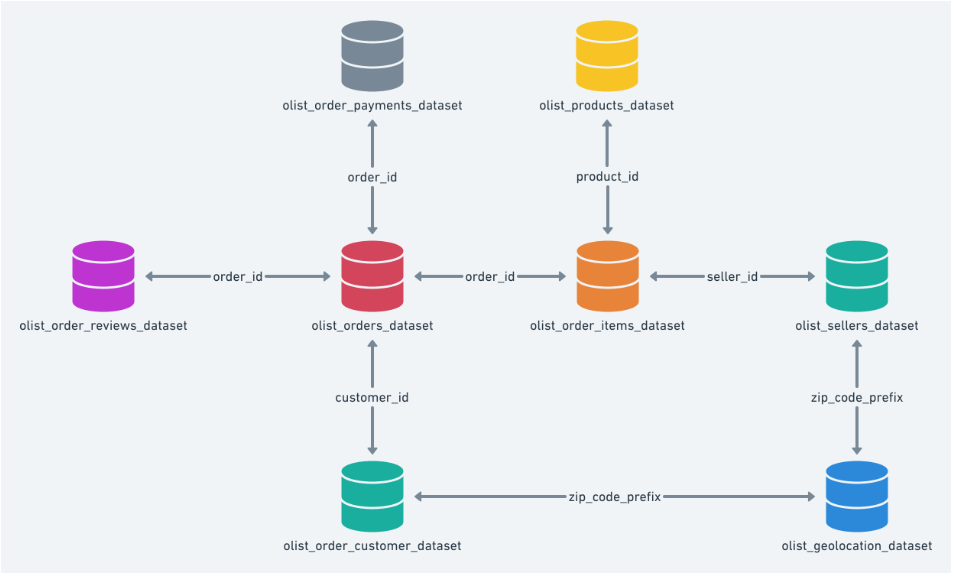

Le schéma ci-dessous nous montre comment sont organisés les tableaux et comment ils sont reliés entre eux. `olist_orders_dataset` est le dataset principal. Avant de réaliser le merge, nous allons analyser individuellement chacun des dataset.

## 2.1 - orders

In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [4]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
orders["order_status"].value_counts(dropna=False)

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [6]:
mask1 = orders["order_delivered_customer_date"].isna()
mask2 = orders["order_status"] == "delivered"
mask = (mask1) & (mask2)
orders.loc[mask, :]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaN,2017-12-18 00:00:00
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaN,2018-07-16 00:00:00
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaN,2018-07-30 00:00:00
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaN,2018-07-30 00:00:00
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaN,2018-07-24 00:00:00
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaN,NaN,2017-06-23 00:00:00
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaN,2018-06-26 00:00:00
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaN,2018-07-19 00:00:00


Nous n'allons conserver pour la suite que les commandes qui ont déja été livrées.

In [7]:
mask = orders["order_status"] == "delivered"
orders = orders.loc[mask, :]

Pour les commandes qui ont été livrées et dont la date de livraison au client est inconnu, nous supposons que la livraison a eu lieu à la date de livraison estimée lors de l'achat `order_estimated_delivery_date`

In [8]:
mask1 = orders["order_delivered_customer_date"].isna()
mask2 = orders["order_status"] == "delivered"
mask = (mask1) & (mask2)
orders.loc[mask, "order_delivered_customer_date"] = \
    orders.loc[mask, "order_estimated_delivery_date"]

Avant d'effectuer le merge, nous allons supprimer certaines colonnes dont nous sommes déja certains qu'elles n'apporteront aucune information qui aiddera à la modélisation : `order_status`, `order_approved_at`, `order_delivered_carrier_date`, `order_estimated_delivery_date`

In [9]:
cols_to_delete = ["order_status", "order_approved_at", 
                  "order_delivered_carrier_date", 
                  "order_estimated_delivery_date",]
orders = orders.drop(columns=cols_to_delete)

Nous allons corriger le type de la colonne `order_purchase_timestamp` et `order_delivered_customer_date`

In [10]:
orders["order_purchase_timestamp"] = \
    pd.to_datetime(orders["order_purchase_timestamp"], 
                   format="%Y-%m-%d %H:%M:%S")

orders["order_delivered_customer_date"] = \
    pd.to_datetime(orders["order_delivered_customer_date"], 
                   format="%Y-%m-%d %H:%M:%S")

Y'a t-il des doublons ?

In [11]:
orders.loc[orders.duplicated("order_id", keep=False), :]

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date


## 2.2 - customers

In [12]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [13]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Avant d'effectuer le merge, nous allons supprimer certaines colonnes dont nous sommes déja certains qu'elles n'apporteront aucune information qui aiddera à la modélisation : `customer_city`.

In [14]:
cols_to_delete = ["customer_city",]
customers = customers.drop(columns=cols_to_delete)

Y'a t-il des doublons ?

In [15]:
customers.loc[customers.duplicated("customer_id", keep=False), :]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_state


## 2.3 - order_items

In [16]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [17]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Avant d'effectuer le merge, nous allons supprimer certaines colonnes dont nous sommes déja certains qu'elles n'apporteront aucune information qui aiddera à la modélisation : `shipping_limit_date`, `seller_id`.

In [18]:
cols_to_delete = ["shipping_limit_date", "seller_id",]
order_items = order_items.drop(columns=cols_to_delete)

Y'a t-il des doublons ?

In [19]:
# Affichons les commandes dont "order_id" apparait au moins 2 fois
mask = order_items["order_id"].duplicated(keep=False)
order_items.loc[mask, :].sort_values("order_id").head(100)

,order_id,order_item_id,product_id,price,freight_value
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,49.90,13.37
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,21.33,15.10
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,21.33,15.10
42,001ab0a7578dd66cd4b0a71f5b6e1e41,1,0b0172eb0fd18479d29c3bc122c058c2,24.89,17.63
43,001ab0a7578dd66cd4b0a71f5b6e1e41,2,0b0172eb0fd18479d29c3bc122c058c2,24.89,17.63
44,001ab0a7578dd66cd4b0a71f5b6e1e41,3,0b0172eb0fd18479d29c3bc122c058c2,24.89,17.63
49,001d8f0e34a38c37f7dba2a37d4eba8b,2,e67307ff0f15ade43fcb6e670be7a74c,18.99,7.78
48,001d8f0e34a38c37f7dba2a37d4eba8b,1,e67307ff0f15ade43fcb6e670be7a74c,18.99,7.78


Nous allons faire un groupby de sorte à avoir des couples uniques (`order_id`, `product_id`)

In [20]:
order_items = order_items.groupby(["order_id", "product_id"])\
                         .agg({"order_item_id": np.max,
                               "price": np.sum,
                               "freight_value": np.sum}).reset_index()

## 2.4 - geolocation

In [21]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [22]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


Nous n'utiliserons pas ce dataset par la suite, car il ne contient aucune information pertinente. Les données sur la localisation des clients sont déja renseignées dans le dataset customers

In [23]:
geolocation["geolocation_zip_code_prefix"].value_counts()

24220    1146
24230    1102
38400     965
35500     907
11680     879
         ... 
71750       1
71742       1
26475       1
26357       1
29826       1
Name: geolocation_zip_code_prefix, Length: 19015, dtype: int64

Nous allons travailler avec les longitudes et latitudes moyennes des différents code_postaux, de sorte à avoir des clés uniques dans la colonne `geolocation_zip_code_prefix`. 

In [24]:
geolocation = geolocation.groupby("geolocation_zip_code_prefix")\
                         .agg({"geolocation_lat" : np.mean,
                               "geolocation_lng" : np.mean}).reset_index()

## 2.5 - order_payments

In [25]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [26]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Avant d'effectuer les premières opérations de nettoyage, nous allons supprimer certaines colonnes dont nous sommes déja certains qu'elles n'apporteront aucune information qui aiddera à la modélisation : `payment_type`

In [27]:
cols_to_delete = ["payment_type",]
order_payments = order_payments.drop(columns=cols_to_delete)

In [28]:
# Affichons les commandes dont "order_id" apparait au moins 2 fois
mask = order_payments["order_id"].duplicated(keep=False)
order_payments.loc[mask, :].sort_values("order_id").head(100)

,order_id,payment_sequential,payment_installments,payment_value
80856,0016dfedd97fc2950e388d2971d718c7,2,1,17.92
89575,0016dfedd97fc2950e388d2971d718c7,1,5,52.63
20036,002f19a65a2ddd70a090297872e6d64e,1,1,44.11
98894,002f19a65a2ddd70a090297872e6d64e,2,1,33.18
30155,0071ee2429bc1efdc43aa3e073a5290e,2,1,92.44
10244,0071ee2429bc1efdc43aa3e073a5290e,1,1,100.00
16459,009ac365164f8e06f59d18a08045f6c4,2,1,4.50
15298,009ac365164f8e06f59d18a08045f6c4,6,1,4.17
32058,009ac365164f8e06f59d18a08045f6c4,4,1,5.45
285,009ac365164f8e06f59d18a08045f6c4,5,1,8.75


Nous allons effectuer un groupby pour n'avoir que des clés uniques dans la colonne `order_id`.

In [29]:
order_payments = order_payments.groupby("order_id")\
                               .agg({"payment_sequential": np.max, 
                                     "payment_installments": np.sum, 
                                     "payment_value": np.sum,})\
                               .reset_index()

Renomons les colonnes

In [30]:
order_payments.rename(columns={"payment_sequential": "nb_payment_method", 
                               "payment_installments": "nb_installments"}, 
                      inplace=True)

## 2.6 - order_reviews

In [31]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [32]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


Nous allons corriger le type de la colonne `review_creation_date`

In [33]:
order_reviews["review_answer_timestamp"] = \
    pd.to_datetime(order_reviews["review_answer_timestamp"], 
                   format="%Y-%m-%d %H:%M:%S")

Y'a t-il des doublons ?

In [34]:
order_reviews.loc[order_reviews.duplicated("order_id" ,keep=False), :]\
             .sort_values("order_id")

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29 00:00:00,2017-08-30 01:59:12
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25 00:00:00,2017-08-29 21:45:57
22779,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22 00:00:00,2018-02-23 12:12:30
68633,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04 00:00:00,2018-03-05 17:02:00
854,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:06
...,...,...,...,...,...,...,...
27465,5e78482ee783451be6026e5cf0c72de1,ff763b73e473d03c321bcd5a053316e8,3,NaN,Não sei que haverá acontecido os demais chegaram,2017-11-18 00:00:00,2017-11-18 09:02:48
41355,39de8ad3a1a494fc68cc2d5382f052f4,ff850ba359507b996e8b2fbb26df8d03,5,NaN,Envio rapido... Produto 100%,2017-08-16 00:00:00,2017-08-17 11:56:55
18783,80f25f32c00540d49d57796fb6658535,ff850ba359507b996e8b2fbb26df8d03,5,NaN,"Envio rapido, produto conforme descrito no anu...",2017-08-22 00:00:00,2017-08-25 11:40:22
92230,870d856a4873d3a67252b0c51d79b950,ffaabba06c9d293a3c614e0515ddbabc,3,NaN,NaN,2017-12-20 00:00:00,2017-12-20 18:50:16


Une commande ne peut avoir qu'une seule évaluation. Nous ne conserverons que l'évaluation la plus récente.

In [35]:
# Tri du dataframe de l'évaluaiton la plus ancienne à la plus récente
order_reviews = order_reviews.sort_values(["review_creation_date"], 
                                          ascending=False)

# Suppression des doublons
order_reviews = order_reviews.drop_duplicates(subset=["order_id"])\
                             .sort_index()

Avant d'effectuer les premières opérations de nettoyage, nous allons supprimer certaines colonnes dont nous sommes déja certains qu'elles n'apporteront aucune information qui aiddera à la modélisation : `review_id`, `review_comment_title`, `review_comment_message`, `review_creation_date`, `review_answer_timestamp`. 

In [36]:
cols_to_delete = ["review_id", "review_comment_title", 
                  "review_comment_message", "review_creation_date", 
                  "review_answer_timestamp",]
order_reviews = order_reviews.drop(columns=cols_to_delete)

## 2.7 - products

In [37]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [38]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


Nous ne conserverons que les colonnes `product_id` et `product_category_name`.

In [39]:
products = products.loc[:, ["product_id", "product_category_name"]]

Nous allons attribuer la valeur **unknown** aux articles dont la catégorie n'est pas renseignée.

In [40]:
products["product_category_name"] = \
    products["product_category_name"].fillna("unknown")

Nous allons effectuer la traduction des catégories à partir du dataset **translation**

In [41]:
# Traduction des catégories en anglais
product_categories_eng = dict(translation.values)
products["product_category_eng"] = \
    products["product_category_name"].map(product_categories_eng)

# Certaines des catégories en protugais n'ont pas été traduites en anglais. 
# Du coup, des NaN sont apparues suite à l'opération ci-dessus.
products["product_category_name"] = \
    products["product_category_eng"].fillna(products["product_category_name"])

# Nous allons maintenant supprimer la colonne "product_category_eng"
products = products.drop(columns="product_category_eng")

Nous allons maintenant regrouper les catégories par thème de sorte à diminuer les modalités. Ces thèmes sont calqués sur ceux de la plateforme **AMAZON**. L'image ci-dessous détaille comment chacune des catégories initiales sera regroupée.
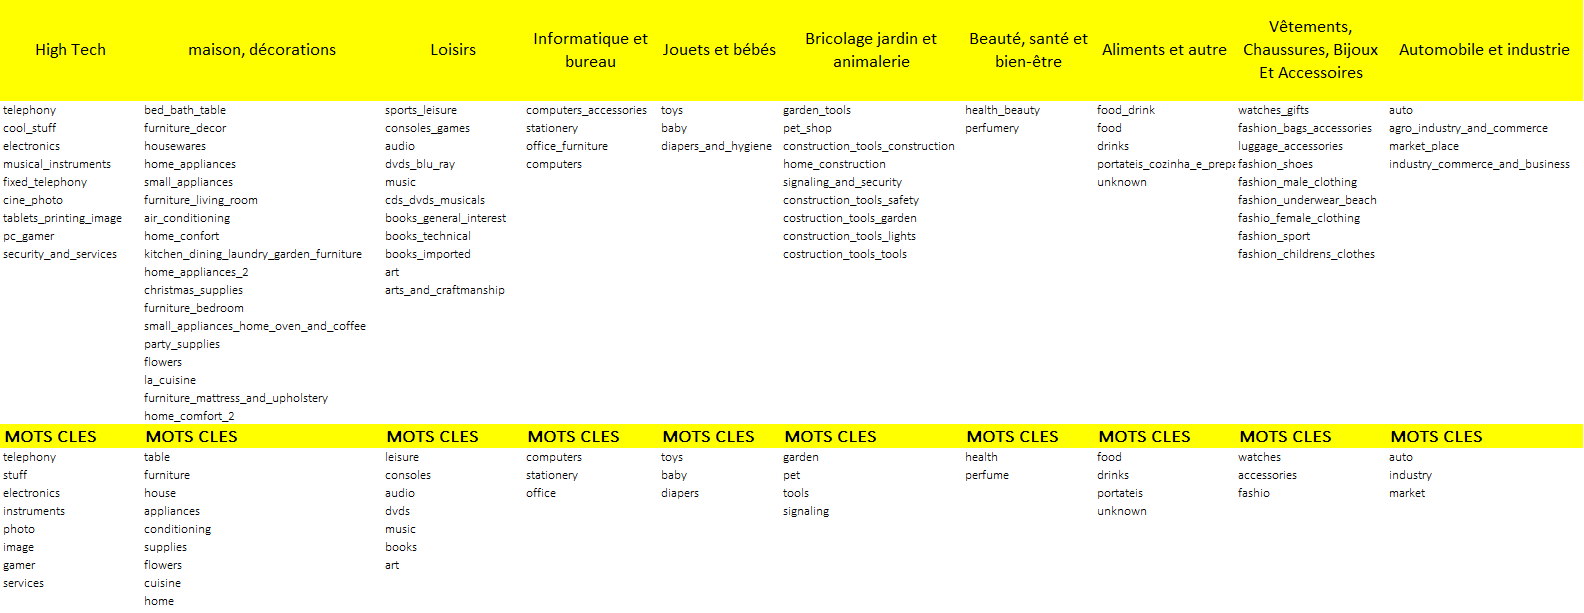

In [42]:
def find_subtring(string, subtrings):
    """
    Detects if at least one of the substrings is in the string
    Args:
        string (String): the text in which we are looking for the words
        subtrings (List): list of the substrings that we want to check 
                          the occurence of in the string
    Returns:
        True if there is at least one word in words that's in text, 
        False otherwise
    """
    # For each subtring in subtrings,
    for subtring in subtrings :
        
        # if subtring in string, return True
        if string.find(subtring) != -1 : 
            return True
        
    # otherwise, return false
    return False

In [43]:
# Mots clés des nouvelles catégories
loisirs = ["leisure", "consoles", "audio", "dvds", "music", "books", "art"]
hightech = ["telephony", "stuff", "electronics", "instruments", "photo", 
             "image", "gamer", "services"]
informatique_bureau = ["computers", "stationery", "office"]
jouets_bébé = ["toys", "baby", "diapers"]
maison_déco = ["table", "furniture", "house", "appliances", "conditioning", 
               "supplies", "flowers", "cuisine", "home"]
brico_jardin_animaux = ["garden", "pet", "tools", "signaling"]
beauté_santé = ["health", "perfume"]
aliments_autres = ["food", "drinks", "portateis", "unknown"]
fashion_accessoires = ["watches", "accessories", "fashio"]
auto_industrie = ["auto", "industry", "market"]

# On enregistre dans une liste
new_categories = {"hightech": hightech, 
                  "maison_déco": maison_déco, 
                  "loisirs": loisirs, 
                  "informatique_bureau": informatique_bureau, 
                  "jouets_bébé": jouets_bébé, 
                  "brico_jardin_animaux": brico_jardin_animaux, 
                  "beauté_santé": beauté_santé, 
                  "aliments_autres": aliments_autres, 
                  "fashion_accessoires": fashion_accessoires, 
                  "auto_industrie": auto_industrie}

# On effectue le regroupement des catégories
for categ in new_categories:
    keywords = new_categories[categ]
    
    # On sélectionne les lignes dont la catégorie contient au moins
    # un des mots clés
    mask = products["product_category_name"].apply(find_subtring, 
                                                   args=([keywords]))
    
    # On modifie le nom de la catégorie
    products.loc[mask, "product_category_name"] = categ

In [44]:
products["product_category_name"].value_counts(dropna=False)

maison_déco             9937
loisirs                 3762
beauté_santé            3312
fashion_accessoires     2899
hightech                2887
informatique_bureau     2518
jouets_bébé             2342
brico_jardin_animaux    2261
auto_industrie          2146
aliments_autres          887
Name: product_category_name, dtype: int64

## 2.8 - sellers

In [45]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [46]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


Nous n'utiliserons pas ce dataset par la suite, car il ne contient aucune information pertinente.

# 3 - Merge et nettoyage des tableaux

### Merge entre customers et geolocation

In [47]:
geolocation.rename(columns={"geolocation_zip_code_prefix": \
                            "customer_zip_code_prefix"}, 
                   inplace=True)
customers = pd.merge(customers, geolocation, on="customer_zip_code_prefix", 
                     how="left")

On va supprimer la colonne `customer_zip_code_prefix`.

In [48]:
customers = customers.drop(columns=["customer_zip_code_prefix"])

Des codes postaux présents dans le dataframe **customers** ne le sont pas dans le dataframe **geolocation**. Pour ces articles, on utilisera la latitude et la longitude moyenne de l'Etat.

In [49]:
def fill_mean(dfunc, feature_cat, feature_num):
    """
    Pairs each row in feature_cat with the mean value of the category 
    associated with that row. The values are those of feature_num.
    Args:
        dfunc (DataFrame)
        feature_cat (string) : a single categorical column of dfunc
        feature_num (string) :  a single numerical column of dfunc
    Returns:
        categ_means (pd.Series)  
    """
    # groupby dfunc with feature_cat
    dfunc_gb = dfunc.groupby(feature_cat)[feature_num].mean().reset_index()
    
    # means : keys are the categories in feature_cat, 
    #         values are the mean values of each category 
    means={}
    
    for category in dfunc_gb[feature_cat].unique():
        means[category] = dfunc_gb.loc[dfunc_gb[feature_cat]==category, 
                                       feature_num].values[0]
     
    categ_means = pd.Series(dfunc[feature_cat].map(means).values)
    
    return categ_means

In [50]:
customers["geolocation_lat"] = \
    customers["geolocation_lat"].fillna(fill_mean(customers, 
                                                  "customer_state", 
                                                  "geolocation_lat"))
customers["geolocation_lng"] = \
    customers["geolocation_lng"].fillna(fill_mean(customers, 
                                                  "customer_state", 
                                                  "geolocation_lng"))

###  Merge entre products et order_items

In [51]:
order_items = pd.merge(order_items, products, on="product_id", how="left")

Nous allons maintenant créer 10 variables synthétiques qui représenteront le montant dépensé dans chaque catégorie d'article par commande.

In [52]:
# On enregistre les catégories des articles dans une liste
categories = order_items.product_category_name.unique().tolist()

# Pour chaque catégorie d'article
for categ in categories:
    
    # Nom de la nouvelle feature
    feature = f"{categ}" + "_value"
    
    # On initialise la valeur dépensée sur cette catégorie
    order_items[feature] = 0
    
    # On calcule le montant dépensé dans cette catégorie pour chaque 
    # commande
    mask = order_items["product_category_name"] == categ
    order_items.loc[mask, feature] = order_items.loc[mask, "price"]

order_items.head()

,order_id,product_id,order_item_id,price,freight_value,product_category_name,hightech_value,brico_jardin_animaux_value,maison_déco_value,beauté_santé_value,loisirs_value,fashion_accessoires_value,aliments_autres_value,auto_industrie_value,informatique_bureau_value,jouets_bébé_value
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,58.90,13.29,hightech,58.9,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,239.90,19.93,brico_jardin_animaux,0.0,239.9,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,199.00,17.87,maison_déco,0.0,0.0,199.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1,12.99,12.79,beauté_santé,0.0,0.0,0.0,12.99,0.0,0.0,0.0,0.0,0.0,0.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1,199.90,18.14,brico_jardin_animaux,0.0,199.9,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


On va maintenant faire un groupby afin de conserver des clés uniques dans la colonne `order_id`

In [53]:
order_items = order_items.groupby(["order_id"])\
                         .agg({"order_item_id": np.max, 
                               "price": np.sum, 
                               "freight_value": np.sum, 
                               "hightech_value": np.sum,
                               "brico_jardin_animaux_value": np.sum,
                               "maison_déco_value": np.sum,
                               "beauté_santé_value": np.sum,
                               "loisirs_value": np.sum,
                               "fashion_accessoires_value": np.sum,
                               "aliments_autres_value": np.sum,
                               "auto_industrie_value": np.sum,
                               "informatique_bureau_value": np.sum,
                               "jouets_bébé_value": np.sum,})\
                         .reset_index()

Renommons les colonnes

In [54]:
order_items.rename(columns={"order_item_id": "nb_items",}, inplace=True)

### Merge entre customers et orders

In [55]:
orders = pd.merge(orders, customers, on="customer_id", how="left")

### Merge entre reviews et orders

In [56]:
orders = pd.merge(orders, order_reviews, on="order_id", how="left")

### Merge entre order_payments et orders

In [57]:
orders = pd.merge(orders, order_payments, on="order_id", how="left")

### Merge entre order_items et orders

In [58]:
orders = pd.merge(orders, order_items, on="order_id", how="left")

Le tableau complet des commandes est reconstitué.

Nous allons nous assurer que chaque clé de `order_id` est associé à une et une seule clé de `customer_id`, comme indiqué sur le site de Olist.

In [59]:
def is_one_to_one(dfunc, col1, col2):
    '''
    Check if two Columns are One-to-One in a DataFrame
    Args :
        dfunc (DataFrame)
        col1 (string) : a column of dfunc
        col2 (string) : a column of dfunc, different from col1
    Returns : 
        True if col1 and col2 are one-to-one. False otherwise
    '''
    f_ = dfunc.drop_duplicates([col1, col2]).groupby(col1)[col2].count().max()
    s_ = dfunc.drop_duplicates([col1, col2]).groupby(col2)[col1].count().max()
    return f_ + s_ == 2

In [60]:
is_one_to_one(orders, "order_id", "customer_id")

True

Nous allons maintenant supprimer la colonne `customer_id`

In [61]:
orders = orders.drop(columns=["customer_id"])

Il y'a une valeur manquante dans les colonnes `nb_payment_method`, `nb_installments` et `payment_value`.

In [62]:
mask = orders["payment_value"].isna()
orders.loc[mask, :]

,order_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,customer_state,geolocation_lat,geolocation_lng,review_score,nb_payment_method,nb_installments,payment_value,nb_items,price,freight_value,hightech_value,brico_jardin_animaux_value,maison_déco_value,beauté_santé_value,loisirs_value,fashion_accessoires_value,aliments_autres_value,auto_industrie_value,informatique_bureau_value,jouets_bébé_value
29811,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,2016-11-09 07:47:38,830d5b7aaa3b6f1e9ad63703bec97d23,SP,-20.585751,-47.863693,1.0,NaN,NaN,NaN,3,134.97,8.49,0.0,0.0,0.0,134.97,0.0,0.0,0.0,0.0,0.0,0.0


Imputons ces valeurs manquantes 

In [63]:
orders["nb_payment_method"] = \
orders["nb_payment_method"].fillna(orders["nb_payment_method"].mode().values[0])

orders["nb_installments"] = \
orders["nb_installments"].fillna(orders["nb_installments"].mode().values[0])

orders["payment_value"] = \
orders["payment_value"].fillna(orders["price"]+orders["freight_value"])

Certaines des valeurs de `nb_installments` sont nulles, ce qui est impossible. Nous les attribuerons la valeur de 1.

In [64]:
mask = orders["nb_installments"] == 0
orders.loc[mask, "nb_installments"] = 1

Il y'a une petite incohérence dans le dataset concernant les variables `payment_value`, `freight_value` et `price`.

In [65]:
mask = abs(orders["payment_value"] \
           - orders["price"] \
           - orders["freight_value"]) > 0.01
orders.loc[mask, :].shape[0]

413

Pour 413 commandes, la somme payée `payment_value` est différente de la somme des prix des articles dans le panier `price` et des frais de transport `freight_value`. Cet écart doit certainement provenir d'autres aspects de la transaction qui n'ont pas été renseignés dans les différents dataset (pénalités de retard de paiement, bons de réduction, etc.). 

Nous allons remplacer les valeurs de `payment_value` par `price`+`freight_value` et suppriemr `price`.

In [66]:
orders["payment_value"] = orders["price"] + orders["freight_value"]
orders = orders.drop(columns=["price"])

Il reste des valeurs manquantes dans la colonne `review_score`

In [67]:
orders["review_score"].isna().sum()

646

Nous allons imputer ces valeurs manquantes de sorte que la distribution de la variable `review_score`reste inchangée.

In [68]:
random.seed(42)
population = orders["review_score"].value_counts().index.tolist()
weights = orders["review_score"].value_counts().values.tolist()
missing_reviews = choices(population, weights, 
                          k=orders["review_score"].isna().sum(),)

mask = orders["review_score"].isna()
orders.loc[mask, "review_score"] = missing_reviews

# 4 - Feature engineering

Nous allons mettre les numéros de commande en index

In [69]:
orders.set_index("order_id", inplace=True)

Nous allons trier le dataset par date d'achat

In [70]:
orders.sort_values("order_purchase_timestamp", inplace=True)

 ### Distance entre le client et les locaux de Olist

In [71]:
def distance(lat1, lon1, lat2, lon2):
    '''
    Haversine distance between 2 points
    Args :
        lat1, lon1 (float): latitude and longitude of the first point
        lat2, lon2 (float): latitude and longitude of the second point
    Returns : 
        d (float): the haversine distance between the 2 points
    '''
    # Conversion en radians
    lon1, lon2, lat1, lat2 = map(radians, [lon1, lon2, lat1, lat2])
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers.
    r = 6371
      
    # calculate the result
    return c * r

In [72]:
# Coordonnées des locaux de Olist
olist_lat = -25.43043943931033
olist_lng = -49.292139311888576

# Calcul de la distance
orders["distance"] = [distance(lat, lng, olist_lat, olist_lng) \
                      for lat,lng in zip(orders["geolocation_lat"], 
                                         orders["geolocation_lng"])]

# Suppression des colonnes
orders.drop(columns=["geolocation_lat", "geolocation_lng",], inplace=True)

### Délai de livraison

In [73]:
orders["delivery_time"] = \
    (orders["order_delivered_customer_date"] - \
     orders["order_purchase_timestamp"]) / np.timedelta64(1,"D")

# Suppression des colonnes
orders.drop(columns=["order_delivered_customer_date"], inplace=True)

### Frais de livraison

Il peut être intéressant de savoir si les frais de livraison ont une incidence sur les habitudes d'achat des clients. Mais pour celà, il faut regarder non pas le montant total des frais de livraison mais le montant total des frais de livraison rapporté au montant total payé pour la commande. En effet, 5€ de livraison sur une commande de 500€ n'est pas similaire à 5€ de livraison sur une commande de 10€. 

In [74]:
orders["freight_ratio"] = orders["freight_value"] / orders["payment_value"]

### Mois d'achat

In [75]:
orders["month_of_purchase"] = orders["order_purchase_timestamp"].dt.month

In [76]:
# Affichons les 5 premières lignes
orders.head()

,order_purchase_timestamp,customer_unique_id,customer_state,review_score,nb_payment_method,nb_installments,payment_value,nb_items,freight_value,hightech_value,brico_jardin_animaux_value,maison_déco_value,beauté_santé_value,loisirs_value,fashion_accessoires_value,aliments_autres_value,auto_industrie_value,informatique_bureau_value,jouets_bébé_value,distance,delivery_time,freight_ratio,month_of_purchase
order_id,,,,,,,,,,,,,,,,,,,,,,,
bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,SP,1.0,1.0,1.0,143.46,3,8.49,0.0,0.0,0.0,134.97,0.00,0.0,0.0,0.0,0.0,0.0,558.173429,54.813194,0.059180,9
3b697a20d9e427646d92567910af6d57,2016-10-03 09:44:50,32ea3bdedab835c3aa6cb68ce66565ef,SP,4.0,1.0,1.0,45.46,1,15.56,0.0,0.0,0.0,0.00,0.00,29.9,0.0,0.0,0.0,0.0,338.428920,23.178738,0.342279,10
be5bc2f0da14d8071e2d45451ad119d9,2016-10-03 16:56:50,2f64e403852e6893ae37485d5fcacdaf,RS,4.0,1.0,1.0,39.09,1,17.19,0.0,0.0,0.0,0.00,21.90,0.0,0.0,0.0,0.0,0.0,525.059423,24.057500,0.439754,10
a41c8759fbe7aab36ea07e038b2d4465,2016-10-03 21:13:36,61db744d2f835035a5625b59350c6b63,RS,3.0,1.0,1.0,53.73,1,17.24,0.0,0.0,0.0,0.00,36.49,0.0,0.0,0.0,0.0,0.0,546.422923,30.572581,0.320864,10
d207cc272675637bfed0062edffd0818,2016-10-03 22:06:03,8d3a54507421dbd2ce0a1d58046826e0,SP,1.0,1.0,6.0,133.46,1,13.56,0.0,0.0,119.9,0.00,0.00,0.0,0.0,0.0,0.0,0.0,354.675164,27.542813,0.101603,10


In [77]:
# dimensions du dataframe
orders.shape

(96478, 23)

### Création d'un fichier client

In [78]:
# Date la plus récente dans le dataset
last_date = orders["order_purchase_timestamp"].max()

customers = orders.groupby(["customer_unique_id"]).agg(
    nb_orders=pd.NamedAgg(column="customer_unique_id", aggfunc="count"),
    distance=pd.NamedAgg(column="distance", aggfunc="last"),
    delivery_time=pd.NamedAgg(column="delivery_time", aggfunc="mean"),
    fav_month_of_purchase=pd.NamedAgg(column="month_of_purchase", 
                                      aggfunc=lambda x: x.mode()[0]),
    most_recent_purchase=pd.NamedAgg(column="order_purchase_timestamp", 
            aggfunc=lambda x: (last_date-x.max())/np.timedelta64(1,"D")),
    nb_payment_method=pd.NamedAgg(column="nb_payment_method", aggfunc="mean"),
    nb_installments=pd.NamedAgg(column="nb_installments", aggfunc="mean"),
    nb_items=pd.NamedAgg(column="nb_items", aggfunc="sum"),
    review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
    amount_spent=pd.NamedAgg(column="payment_value", aggfunc="sum"),
    freight_ratio=pd.NamedAgg(column="freight_value", aggfunc="sum"),
    hightech_spent=pd.NamedAgg(column="hightech_value", aggfunc="sum"),
    brico_jardin_animaux_spent=\
            pd.NamedAgg(column="brico_jardin_animaux_value", aggfunc="sum"),
    maison_déco_spent=pd.NamedAgg(column="maison_déco_value", aggfunc="sum"),
    beauté_santé_spent=pd.NamedAgg(column="beauté_santé_value", aggfunc="sum"),
    loisirs_spent=pd.NamedAgg(column="loisirs_value", aggfunc="sum"),
    fashion_accessoires_spent=\
            pd.NamedAgg(column="fashion_accessoires_value", aggfunc="sum"),
    aliments_autres_spent=pd.NamedAgg(column="aliments_autres_value", 
                                      aggfunc="sum"),
    auto_industrie_spent=pd.NamedAgg(column="auto_industrie_value", 
                                     aggfunc="sum"),
    informatique_bureau_spent=\
            pd.NamedAgg(column="informatique_bureau_value", aggfunc="sum"),
    jouets_bébé_spent=pd.NamedAgg(column="jouets_bébé_value", aggfunc="sum"),
)
customers["freight_ratio"]=customers["freight_ratio"]/customers["amount_spent"]

In [79]:
# Affichons les 5 premières lignes
customers.head()

,nb_orders,distance,delivery_time,fav_month_of_purchase,most_recent_purchase,nb_payment_method,nb_installments,nb_items,review_score,amount_spent,freight_ratio,hightech_spent,brico_jardin_animaux_spent,maison_déco_spent,beauté_santé_spent,loisirs_spent,fashion_accessoires_spent,aliments_autres_spent,auto_industrie_spent,informatique_bureau_spent,jouets_bébé_spent
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,340.846741,6.411227,5,111.169560,1.0,8.0,1,5.0,141.90,0.084567,0.00,0.0,129.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,327.889025,3.285590,5,114.159144,1.0,1.0,1,4.0,27.19,0.304892,0.00,0.0,0.0,18.9,0.0,0.0,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,1,243.867771,25.731759,3,536.746921,1.0,8.0,1,3.0,86.22,0.199722,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,1,2683.227115,20.037083,10,320.771481,1.0,4.0,1,4.0,43.62,0.404172,25.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,1,282.536956,13.141134,11,287.802025,1.0,6.0,1,5.0,196.89,0.085784,180.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
# Dimensions du tableau
customers.shape

(93358, 21)

**Nous n'allons pas supprimer les outliers car ces individus pourraient justement représenter les meilleurs clients de l'entreprise.**

# 4 - Analyse exploratoire

In [81]:
customers.describe()

,nb_orders,distance,delivery_time,fav_month_of_purchase,most_recent_purchase,nb_payment_method,nb_installments,nb_items,review_score,amount_spent,freight_ratio,hightech_spent,brico_jardin_animaux_spent,maison_déco_spent,beauté_santé_spent,loisirs_spent,fashion_accessoires_spent,aliments_autres_spent,auto_industrie_spent,informatique_bureau_spent,jouets_bébé_spent
count,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000
mean,1.033420,720.367074,12.568435,6.002078,237.467372,1.044682,2.965011,1.180370,4.153193,165.168210,0.208142,14.251937,10.340248,36.219728,17.387652,13.481737,16.090931,2.569294,7.667552,14.259061,9.353340
std,0.209097,612.621485,9.546400,3.224831,152.593265,0.364399,2.716165,0.620857,1.280862,226.292101,0.124863,95.009767,71.172175,111.711887,77.400205,74.013577,86.462962,32.859718,66.694607,93.490496,58.452105
min,1.000000,0.675146,0.533414,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,9.590000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,340.976401,6.788452,3.000000,113.901415,1.000000,1.000000,1.000000,4.000000,63.010000,0.116608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,497.073634,10.234780,6.000000,218.616950,1.000000,2.000000,1.000000,5.000000,107.780000,0.183194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,819.417847,15.720182,8.000000,345.857894,1.000000,4.000000,1.000000,5.000000,182.510000,0.274458,0.000000,0.000000,26.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.000000,8594.473953,209.628611,12.000000,713.113877,26.000000,26.000000,24.000000,5.000000,13664.080000,0.955451,13440.000000,3930.000000,7388.000000,3124.000000,6499.000000,4400.000000,3980.000000,5934.600000,6729.000000,3899.000000


## 4.1 - Analyse univariée

### nb_orders

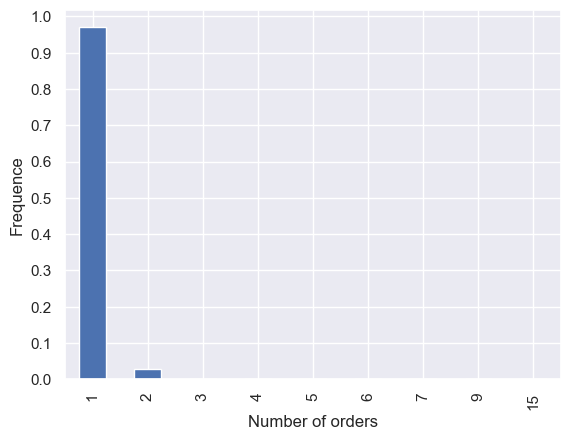

In [107]:
customers["nb_orders"].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.xlabel("Number of orders")
plt.ylabel("Frequence")
plt.yticks(np.arange(0, 1.01 ,0.1))
plt.show()

Presque 100% des individus sont des clients ayant effectué une seule commande.

### distance

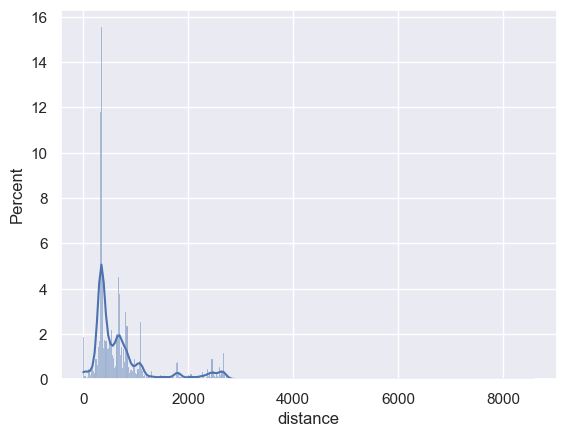

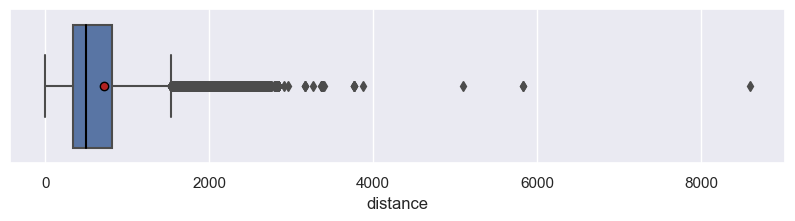

In [83]:
sns.histplot(customers, x="distance", stat="percent", kde=True)
plt.show()

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 
             'markerfacecolor':'firebrick'}

plt.figure(figsize=(10,2))
sns.boxplot(data=customers, x="distance", showmeans=True, 
            medianprops=medianprops, meanprops=meanprops)
plt.show()

Olist a apparemment quelques clients à l'autre bout de la planète.

### delivery_time

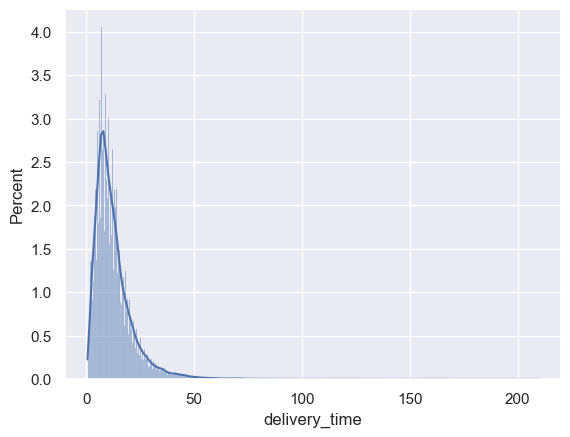

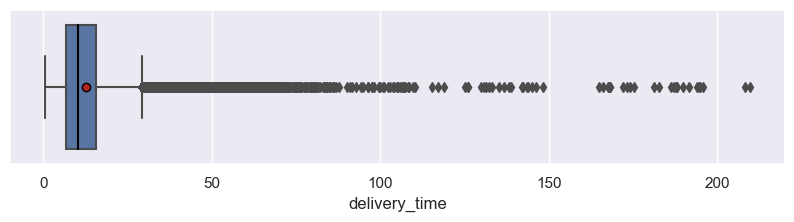

In [84]:
sns.histplot(customers, x="delivery_time", stat="percent", kde=True)
plt.show()

plt.figure(figsize=(10,2))
sns.boxplot(data=customers, x="delivery_time", showmeans=True, 
            medianprops=medianprops, meanprops=meanprops)
plt.show()

Les délais de livraison de Olist sont assez longs.

### customer_state

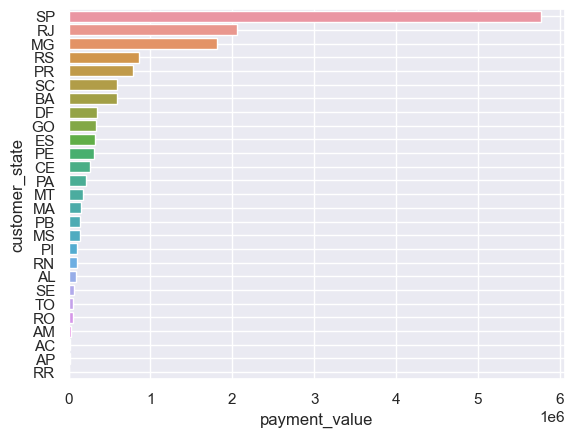

In [85]:
state_sales = orders.groupby(["customer_state"])[["payment_value"]].sum()\
                    .sort_values("payment_value", ascending=False)\
                    .reset_index()
sns.barplot(data=state_sales, x="payment_value", y="customer_state")
plt.grid("x")
plt.show()

Sao Paulo est de loin l'état le plus prolifique pour Olist. Rio de Janeiro et Minas Gerais sont les 2 autres Etats qui se détachent.

### fav_month_of_purchase

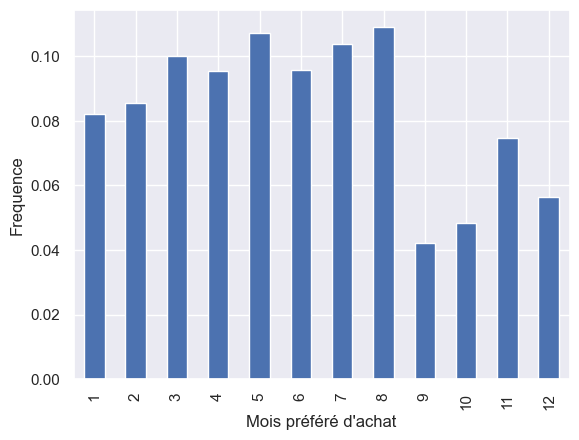

In [86]:
customers["fav_month_of_purchase"].value_counts(normalize=True)\
                                  .sort_index().plot(kind='bar')
plt.xlabel("Mois préféré d'achat")
plt.ylabel("Frequence")
plt.show()

Les achats se font beaucoup plus pendant les 8 premiers mois de l'année. En particulier, la période [mai - août] est celle durant laquelle les utilisateurs font le plus d'achat. Par contre en [septembre - octobre], les ventes sont faibles.

### most_recent_purchase

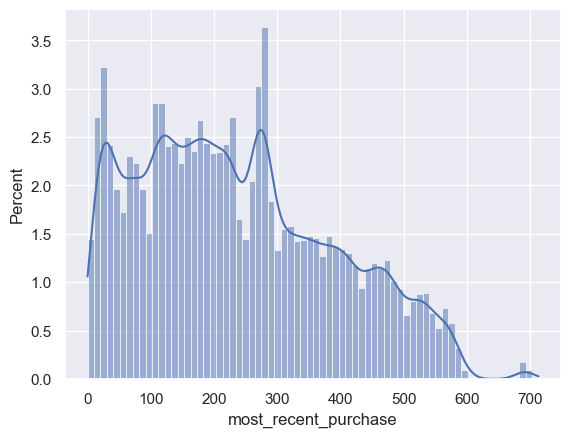

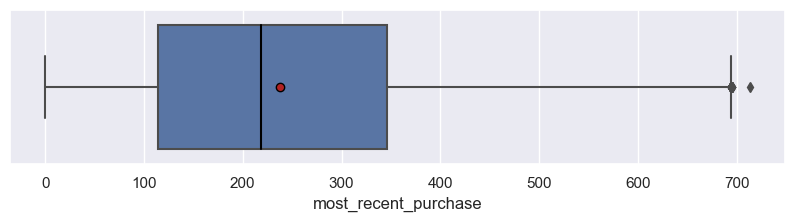

In [87]:
sns.histplot(customers, x="most_recent_purchase", stat="percent", kde=True)
plt.show()

plt.figure(figsize=(10,2))
sns.boxplot(data=customers, x="most_recent_purchase", showmeans=True, 
            medianprops=medianprops, meanprops=meanprops)
plt.show()

On peut voir que les ventes étaient plutôt constantes pendant les 300 premiers jours. Puis elles se sont écoulées rapidement après celà.

### nb_payment_method

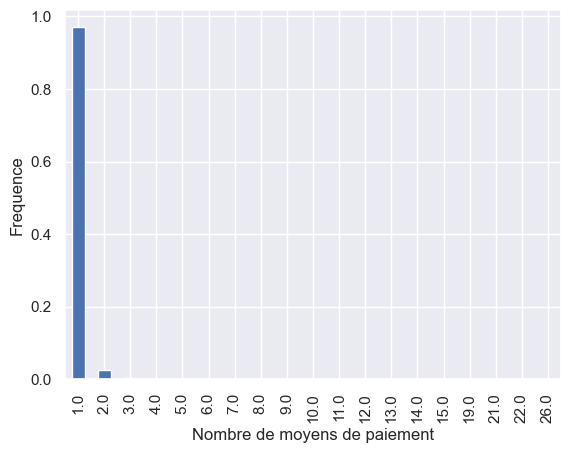

In [88]:
orders["nb_payment_method"].value_counts(normalize=True)\
                           .sort_index().plot(kind='bar')
plt.xlabel("Nombre de moyens de paiement")
plt.ylabel("Frequence")
plt.show()

Presque tous les clients utilisent un seul moyen de paiement pour réaliser leurs commandes.

### nb_installments

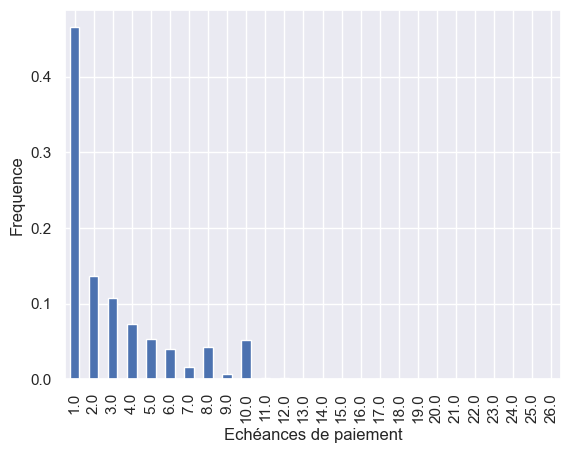

In [89]:
orders["nb_installments"].value_counts(normalize=True)\
                         .sort_index().plot(kind='bar')
plt.xlabel("Echéances de paiement")
plt.ylabel("Frequence")
plt.show()

La plupart des clients paie leur commande en une fois.

### nb_items

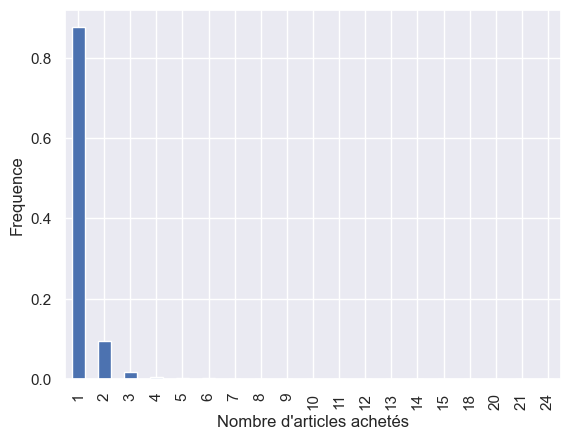

In [90]:
customers["nb_items"].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.xlabel("Nombre d'articles achetés")
plt.ylabel("Frequence")
plt.show()

8 commandes sur 10 ne contiennent qu'un seul article dans le panier.

### review_score

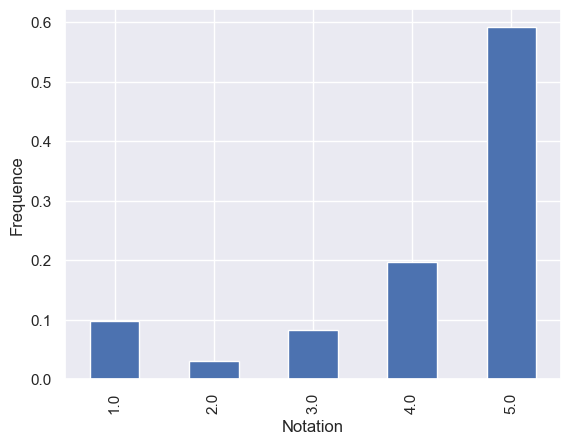

In [91]:
orders["review_score"].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.xlabel("Notation")
plt.ylabel("Frequence")
plt.show()

Les clients sont en général très satisfaits des commandes qu'ils réalisent sur Olist.

### amount_spent

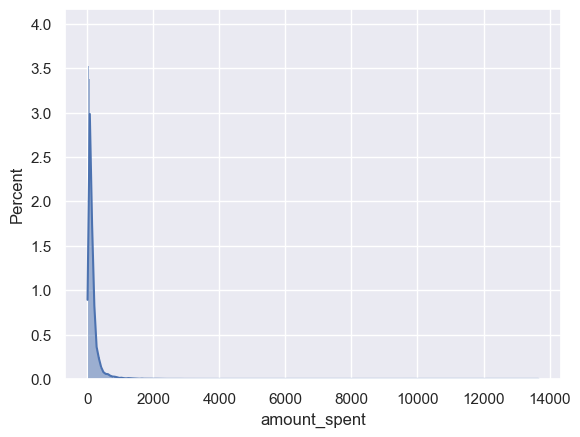

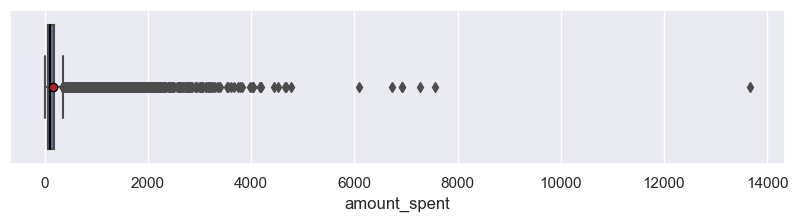

In [92]:
sns.histplot(customers, x="amount_spent", stat="percent", kde=True,)
plt.show()

plt.figure(figsize=(10,2))
sns.boxplot(data=customers, x="amount_spent", showmeans=True, 
            medianprops=medianprops, meanprops=meanprops)
plt.show()

Il y'a quelques clients exceptionnels qui ont dépensé plus de 6000€ chez Olist.

### freight_ratio

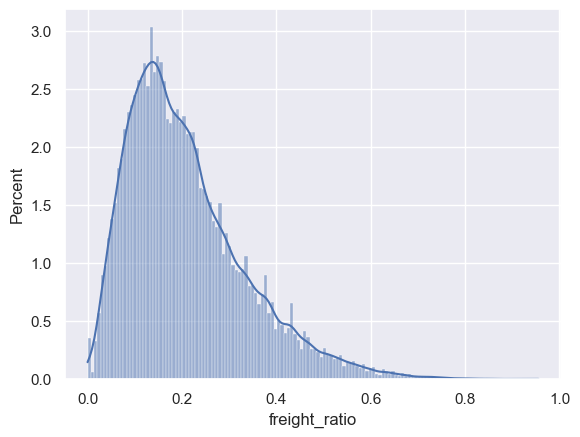

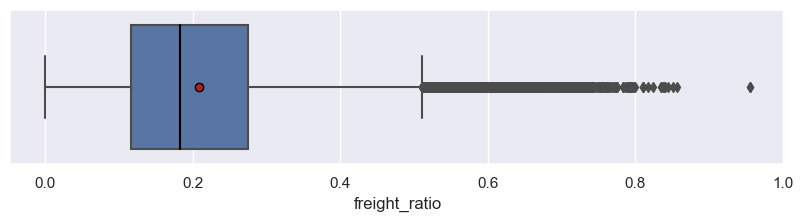

In [93]:
sns.histplot(customers, x="freight_ratio", stat="percent", kde=True,)
plt.show()

plt.figure(figsize=(10,2))
sns.boxplot(data=customers, x="freight_ratio", showmeans=True, 
            medianprops=medianprops, meanprops=meanprops)
plt.show()

### Dépenses dans chaque catégorie

In [94]:
categories=["hightech_spent", "brico_jardin_animaux_spent", 
            "maison_déco_spent", "beauté_santé_spent", 
            "loisirs_spent", "fashion_accessoires_spent", 
            "aliments_autres_spent", "auto_industrie_spent", 
            "informatique_bureau_spent", "jouets_bébé_spent"]
categories_data = customers[categories]\
                 .aggregate(func=["sum", lambda x: x[x!=0].shape[0]]).T\
                 .sort_index()
categories_data.index = sorted(list(new_categories.keys()))
categories_data.columns = ["total", "nb_orders"]
categories_data["amount_per_order"] = \
    categories_data["total"] / categories_data["nb_orders"]
categories_data.reset_index(inplace=True)
categories_data.rename(columns={"index": "category"}, inplace=True)
categories_data

,category,total,nb_orders,amount_per_order
0,aliments_autres,239864.13,2333.0,102.813601
1,auto_industrie,715827.33,4448.0,160.932403
2,beauté_santé,1623276.37,11523.0,140.872722
3,brico_jardin_animaux,965344.91,6619.0,145.844525
4,fashion_accessoires,1502217.15,8687.0,172.927035
5,hightech,1330532.33,11043.0,120.486492
6,informatique_bureau,1331197.44,8825.0,150.843903
7,jouets_bébé,873209.11,6543.0,133.456994
8,loisirs,1258628.01,9810.0,128.300511
9,maison_déco,3381401.33,25359.0,133.341273


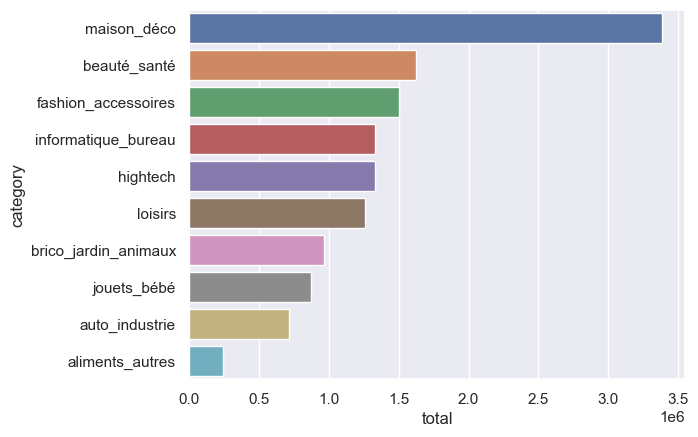

In [95]:
sns.barplot(data=categories_data.sort_values("total", ascending=False),
            y="category", x="total")
plt.show()

Olist fait son plus gros chiffre d'affaire dans les articles de maison et décoration.

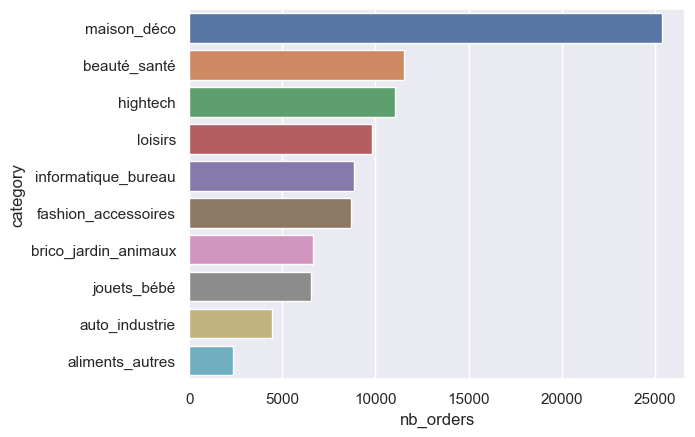

In [96]:
sns.barplot(data=categories_data.sort_values("nb_orders", ascending=False),
            y="category", x="nb_orders")
plt.show()

C'est également les produits de décoration ou de maison qui apparaissent le plus dans les paniers des commandes.

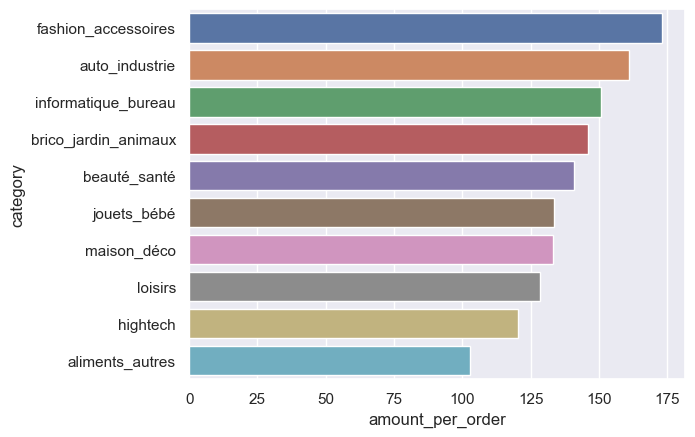

In [97]:
sns.barplot(data=categories_data.sort_values("amount_per_order", ascending=False),
            y="category", x="amount_per_order")
plt.show()

En général, dans chaque commande pour des articles de mode, les clients d'Olist dépensent le plus.

## 4.2 - Analyse en composantes principales

Les fonctions pour projeter les variables et les individus ont été écrit par dans un script Python à part et importés (plot_pca). En effet, nous avons déja écrit ces fonctions pour les projets précédents d'OC et il est rébarbatif de les copier/coller chaque fois dans chaque projet. Ces fichiers seront inclus dans le rendu du projet.

Nombre de composantes principales : 21

Variance expliquée par les axes principaux :


array([1.095e+01, 7.560e+00, 6.960e+00, 5.260e+00, 5.100e+00, 5.060e+00,
       4.990e+00, 4.940e+00, 4.890e+00, 4.880e+00, 4.850e+00, 4.820e+00,
       4.790e+00, 4.710e+00, 4.530e+00, 4.470e+00, 3.440e+00, 3.100e+00,
       2.470e+00, 2.230e+00, 1.000e-02])

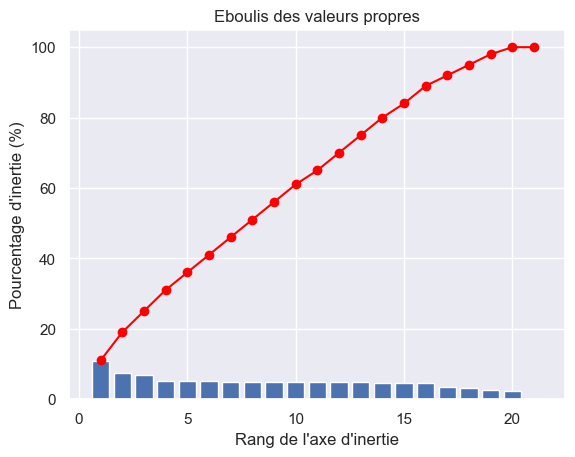

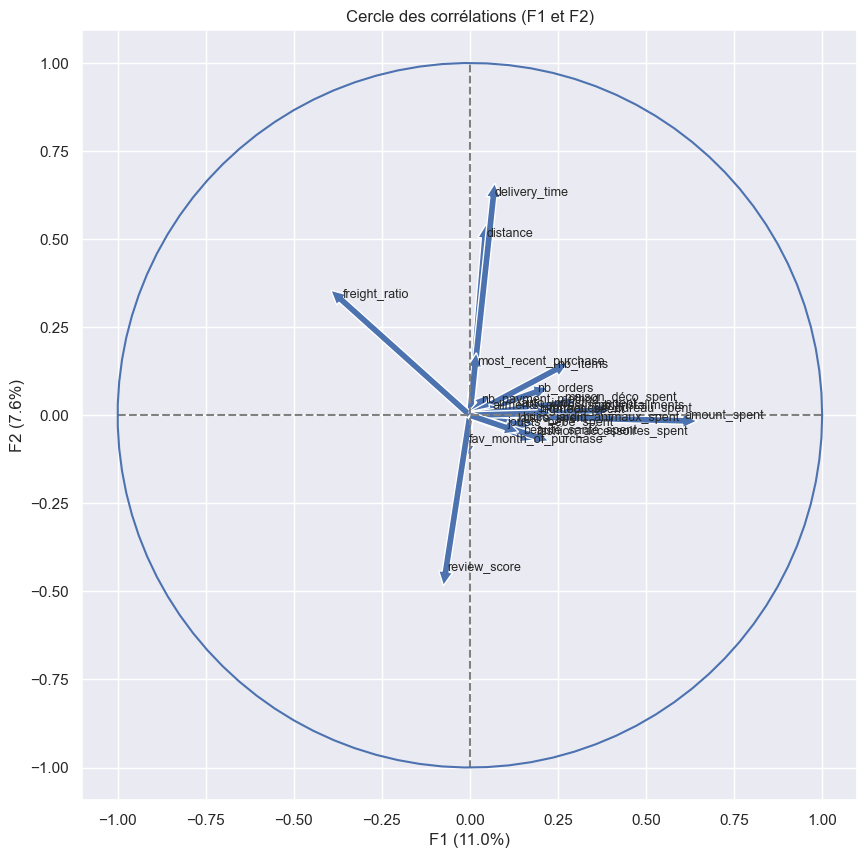

In [98]:
# On enregistre le nom des composantes actives et illustratives
features_active = customers.columns

# On split le jeu de données
X_active = customers[features_active].values

# On enregistre le nom des individus
names = customers.index

# Centrage-réduction
scaler = StandardScaler()
X_active_scaled = scaler.fit_transform(X_active)

# Instanciation de l'ACP
pca = PCA()
pca.fit(X_active_scaled)

# Eboulis des valeurs propres
    # nombre de valeurs propres / composantes principales
n_components = pca.n_components_
print("Nombre de composantes principales :", n_components)

    # Inertie des axex principaux
scree = (pca.explained_variance_ratio_*100).round(2)
print("\nVariance expliquée par les axes principaux :")
display(scree)

    # Inertie cumulée
scree_cum = scree.cumsum().round()

    # Indices des axes principaux
x_list = range(1, n_components+1)

    # Affichage de l'éboulis
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie (%)")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

# Plan (F1, F2)
plot_features(pca, X_active_scaled, [0,1], features_active,)

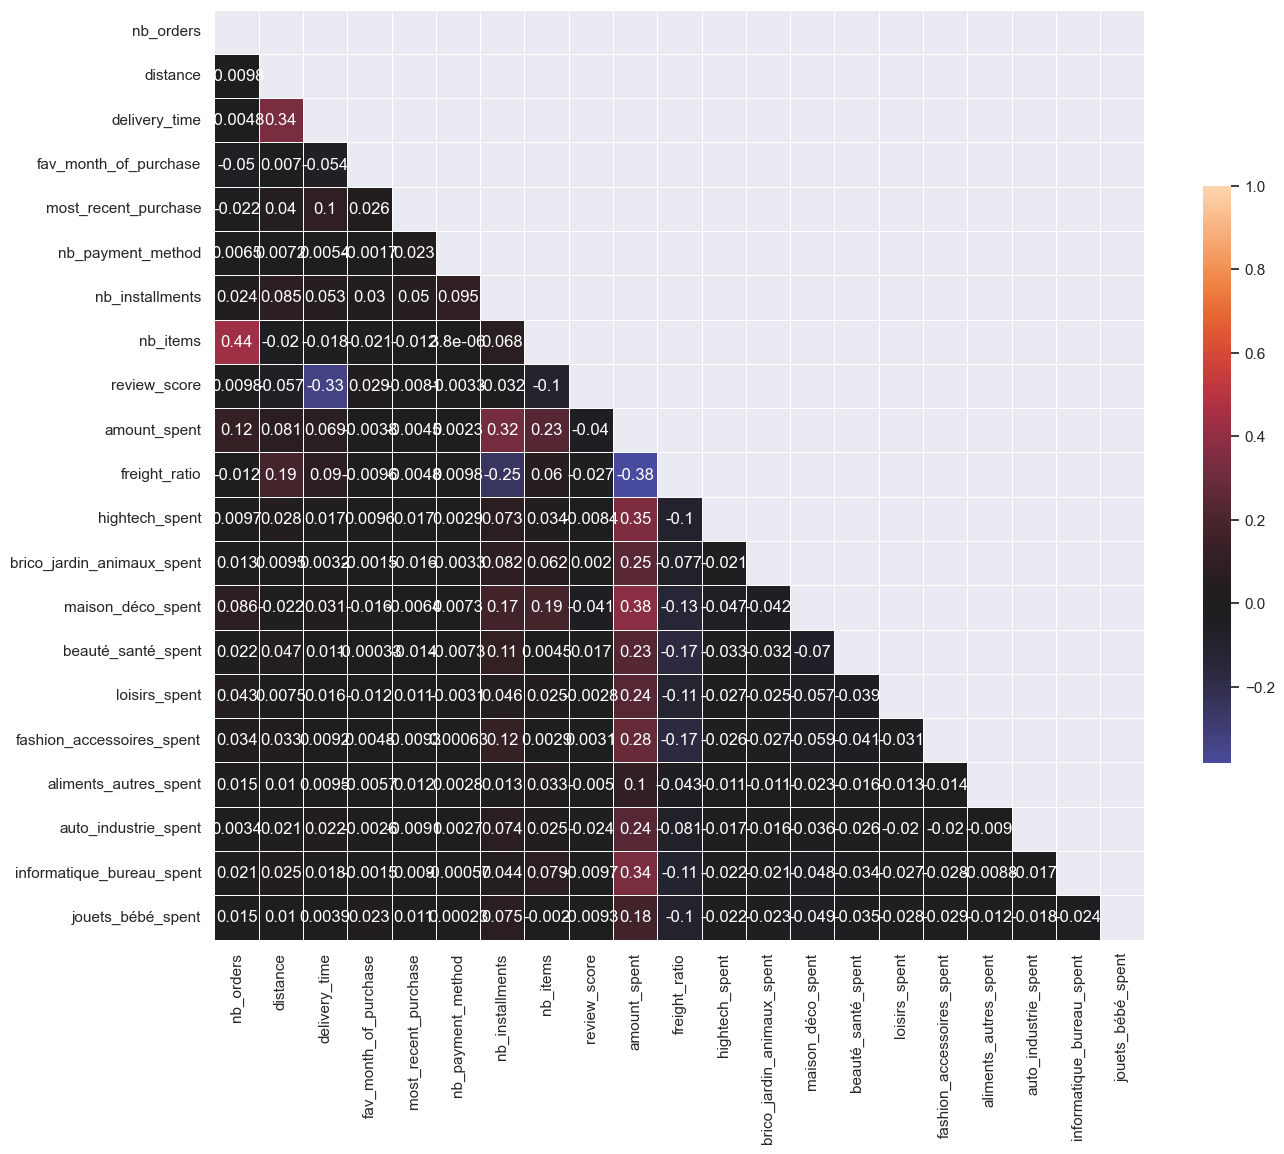

In [99]:
# compute the correlation matrix
corr = customers.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=corr,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

#### ----> Objectif de l'ACP
Déterminer un bilan des liaisons (corrélations) entre les différentes variables. On pourra également le cas échéant résumer ces variables par quelques variables de synthèse (les facteurs de l'ACP)

#### ----> Qualité de la représentation
La qualité globale de la représentation est assez mauvaise. Le premier plan factoriel ne représente que près de 17.6% de la variance. Sachant qu'il y'a 21 variables, ce qui signifie que variable représente 4.8% de la variance totale, les 2 premiers facteurs ne capturent donc qu'un peu plus de 3 variables. 

#### ---> Matrice des corrélations
Ce qui saute aux yeux en consultant la matrice de corrélation est que les coefficients sont tous faibles. La corrélation la plus forte vaut 0.44 seulement (entre le nombre de commandes et le nombre d'articles commandés).

#### ---> Premier plan factoriel
- Le graphe des variables montre qu'aucune variable n'est bien représentée (la pointe des flèches est loin du cercle). Ce résultat est attendu compte tenu du pourcentage d'inertie associée au plan. Le coefficient de corrélation 
- 15 des 21 variables sont proches du centre du graphe, ce qui traduit une corrélation très faible avec les 2 premiers axes factoriels. 
- Le premier axe est surtout attiré par la somme dépensée. On peut aussi y lire aussi que plus on dépense, moins on est impacté par les frais de livraison. 
- Le second axe oppose les délais de livraison aux notations. On voit aussi que le délai de livraison augmente avec la distance, ce qui est logique. 

# 5 - Enregistrement du fichier

In [100]:
# Sauvegarde des fichiers
orders.to_csv(r".\orders.csv", index=True)
customers.to_csv(r".\customers.csv", index=True)